# Project 12 - Convolutional Neural Network MNIST

# Step 1 - Libraries

In [3]:
import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets
from torchvision import transforms

# Step 2 - Dataset

In [4]:
torch.manual_seed(123)

In [5]:
transform = transforms.ToTensor()

In [6]:
train = datasets.MNIST(root='.', train=True, download=True, transform=transform)
test = datasets.MNIST(root='.', train=False, download=True, transform=transform)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:25<00:00, 387304.96it/s]


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 204857.80it/s]


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:01<00:00, 1571649.19it/s]


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 25400705.02it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



In [8]:
train.data[0]

tensor([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   3,  18,
          18,  18, 126, 136, 175,  26, 166, 255, 247, 127,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   

In [11]:
train.data.shape

torch.Size([60000, 28, 28])

In [12]:
train.targets

tensor([5, 0, 4,  ..., 5, 6, 8])

In [13]:
train_loader = torch.utils.data.DataLoader(train, batch_size=128)
test_loader = torch.utils.data.DataLoader(test, batch_size=128)

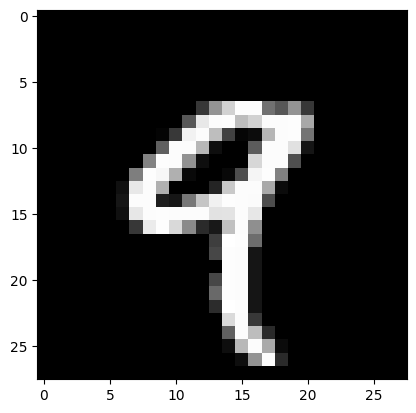

In [20]:
image = next(iter(train_loader))[0][4].view(28, 28)
plt.imshow(image, cmap='gray')

In [21]:
image.shape

torch.Size([28, 28])

(array([664.,   6.,   9.,   8.,   6.,   8.,   5.,   9.,   8.,  61.]),
 array([0.        , 0.1       , 0.2       , 0.30000001, 0.40000001,
        0.5       , 0.60000002, 0.69999999, 0.80000001, 0.89999998,
        1.        ]),
 <BarContainer object of 10 artists>)

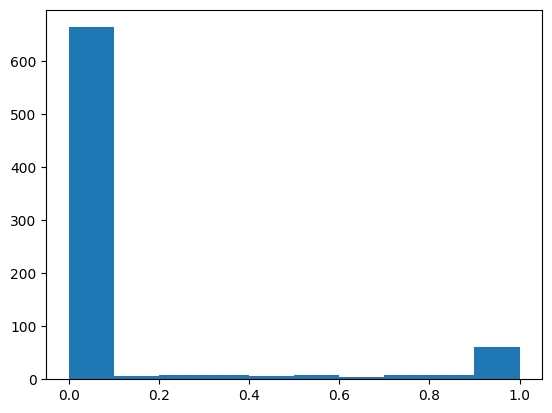

In [22]:
plt.hist(image.view(-1))

# Step 3 - Model building

In [23]:
class classifier(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=(3,3)) # one color input, 32 output channels
        self.conv2 = nn.Conv2d(32, 32, (3,3))
        self.activation = nn.ReLU()

        self.bnorm = nn.BatchNorm2d(num_features=32)
        self.pool = nn.MaxPool2d(kernel_size=(2,2))
        self.flatten = nn.Flatten()

        # 800 -> 128 
        # output = (input - filter +1) / stride
        # conv1 = (28 - 3 + 1) / 1 = 26 -> 28 is the input size, 3 is the filter size, 1 is the stride
        # pool1 = (26 - 2 + 1) / 2 = 13 -> 26 is the input size, 2 is the filter size, 1 is the stride
        # conv2 = (13 - 3 + 1) / 1 = 11 -> 13 is the input size, 3 is the filter size, 1 is the stride
        # pool2 = (11 - 2 + 1) / 2 = 5 -> 11 is the input size, 2 is the filter size, 1 is the stride
        # the image is now 5x5
        # 5 * 5 * 32 = 800 -> 32 is the number of output channels

        self.linear1 = nn.Linear(in_features=32*5*5, out_features=128)
        self.linear2 = nn.Linear(128, 128)
        self.output = nn.Linear(128, 10) # we have 10 classes
        self.dropout = nn.Dropout(p=0.2)

    def forward(self, X):
        X = self.pool(self.bnorm(self.activation(self.conv1(X))))
        X = self.pool(self.bnorm(self.activation(self.conv2(X))))
        X = self.flatten(X)

        X = self.dropout(self.activation(self.linear1(X)))
        X = self.dropout(self.activation(self.linear2(X)))
        X = self.output(X)

        return X



In [25]:
net = classifier()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters())

# Step 4 - Model training

In [26]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [27]:
net.to(device)

classifier(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
  (activation): ReLU()
  (bnorm): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear1): Linear(in_features=800, out_features=128, bias=True)
  (linear2): Linear(in_features=128, out_features=128, bias=True)
  (output): Linear(in_features=128, out_features=10, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)

In [28]:
def train_loop(loader, epoch):
    running_loss = 0
    running_accuracy = 0

    for i, data in enumerate(loader):
        inputs, labels = data

        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = net(inputs)

        loss = criterion(outputs, labels)
        loss.backward()

        optimizer.step()

        running_loss += loss.item()

        ps = F.softmax(outputs)
        top_p, top_class = ps.topk(k = 1, dim = 1)
        equals = top_class == labels.view(*top_class.shape)

        accuracy = torch.mean(equals.type(torch.float))


        running_accuracy += accuracy

        print(f'Epoch: {epoch}, Batch: {i}, Loss: {loss}, Accuracy: {accuracy}')
    
    print(f'Epoch: {epoch}, Loss: {running_loss/len(loader)}, Accuracy: {running_accuracy/len(loader)}')

    

In [30]:
for epoch in range(5):
    print(f'Epoch: {epoch}')
    train_loop(train_loader, epoch)
    net.eval()

    print('Testing')
    train_loop(test_loader, epoch)
    net.train()


Epoch: 0
Epoch: 0, Batch: 0, Loss: 0.024465838447213173, Accuracy: 0.9921875
Epoch: 0, Batch: 1, Loss: 0.09872777760028839, Accuracy: 0.984375
Epoch: 0, Batch: 2, Loss: 0.05060483515262604, Accuracy: 0.9921875


/tmp/ipykernel_7167/3157752744.py:20: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  ps = F.softmax(outputs)


Epoch: 0, Batch: 3, Loss: 0.09324637055397034, Accuracy: 0.9765625
Epoch: 0, Batch: 4, Loss: 0.031524501740932465, Accuracy: 0.9921875
Epoch: 0, Batch: 5, Loss: 0.04231029376387596, Accuracy: 0.984375
Epoch: 0, Batch: 6, Loss: 0.04860639572143555, Accuracy: 0.984375
Epoch: 0, Batch: 7, Loss: 0.05050100013613701, Accuracy: 0.984375
Epoch: 0, Batch: 8, Loss: 0.0414893664419651, Accuracy: 0.984375
Epoch: 0, Batch: 9, Loss: 0.02588081732392311, Accuracy: 0.9921875
Epoch: 0, Batch: 10, Loss: 0.0416053831577301, Accuracy: 0.9921875
Epoch: 0, Batch: 11, Loss: 0.014964098110795021, Accuracy: 1.0
Epoch: 0, Batch: 12, Loss: 0.023985901847481728, Accuracy: 0.9921875
Epoch: 0, Batch: 13, Loss: 0.007028053980320692, Accuracy: 1.0
Epoch: 0, Batch: 14, Loss: 0.04720953106880188, Accuracy: 0.9765625
Epoch: 0, Batch: 15, Loss: 0.07336022704839706, Accuracy: 0.984375
Epoch: 0, Batch: 16, Loss: 0.005908803083002567, Accuracy: 1.0
Epoch: 0, Batch: 17, Loss: 0.01243351586163044, Accuracy: 1.0
Epoch: 0, Bat

# Step 5 - Model evaluation

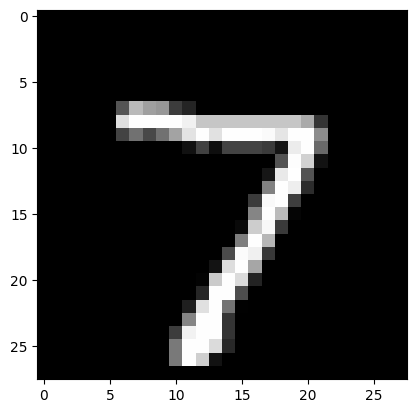

In [31]:
image = next(iter(test_loader))[0][0].view(28, 28)
plt.imshow(image, cmap='gray')

In [32]:
# (1, 1, 28, 28) - (batch, color, height, width)
image.shape

torch.Size([28, 28])

In [33]:
image = image.view(1,1,28,28)

In [34]:
image.shape

torch.Size([1, 1, 28, 28])

In [35]:
net.eval()

classifier(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
  (activation): ReLU()
  (bnorm): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear1): Linear(in_features=800, out_features=128, bias=True)
  (linear2): Linear(in_features=128, out_features=128, bias=True)
  (output): Linear(in_features=128, out_features=10, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)

In [36]:
image = image.to(device)

forecast = net.forward(image)
forecast

tensor([[ -4.1606,  -2.7881,  -1.2881,  -0.5853,  -3.1578,  -5.2321, -12.0607,
          10.9540,  -3.7738,  -0.1944]], device='cuda:0',
       grad_fn=<AddmmBackward0>)

In [37]:
forecast = F.softmax(forecast)
forecast

/tmp/ipykernel_7167/900664498.py:1: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  forecast = F.softmax(forecast)


tensor([[2.7278e-07, 1.0762e-06, 4.8232e-06, 9.7396e-06, 7.4355e-07, 9.3429e-08,
         1.0112e-10, 9.9997e-01, 4.0160e-07, 1.4398e-05]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)

In [38]:
forecast = forecast.cpu().detach().numpy()

In [39]:
result = np.argmax(forecast)

In [40]:
result

7